In [1]:
!nvidia-smi

Tue Mar 22 05:17:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f8dacd6c110>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
print('훈련용 리뷰 개수 :', len(train_data))
print('테스트용 리뷰 개수 :', len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [6]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [7]:
# 중복제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [8]:
print('총 샘플의 수 :', len(train_data))

총 샘플의 수 : 146183


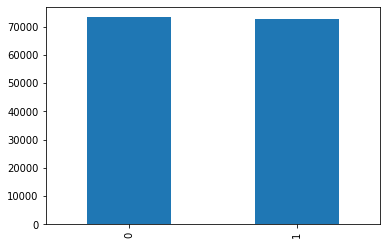

In [9]:
train_data['label'].value_counts().plot(kind='bar')

In [10]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [11]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [12]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('',np.nan, inplace=True)

test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('',np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [13]:
# nan값 제거
train_data = train_data.dropna()
test_data = test_data.dropna()

In [14]:
train_data.isnull().sum()
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

## 토크나이저를 이용한 정수 인코딩

In [15]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 6.9 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 16.2 MB/s 
     |████████████████████████████████| 6.5 MB 49.8 MB/s 
     |████████████████████████████████| 895 kB 51.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [16]:
import transformers

In [17]:
transformers.__version__

'4.17.0'

In [18]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [19]:
X_train_list = train_data['document'].tolist()
X_test_list = test_data['document'].tolist()
y_train = train_data['label'].tolist() # label 긍부정 표시
y_test = test_data['label'].tolist()

In [20]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [21]:
len(X_train[0])

98

In [ ]:
X_train[0].tokens

In [ ]:
X_train[0].ids

In [ ]:
X_train[0].type_ids # 문장의 종류의 개수, 이 데이터는 문장 1개

In [ ]:
X_train[0].attention_mask # 패딩 구분 (패딩부분 0으로 표시)

## 데이터셋 생성 및 모델 학습

In [26]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test))

In [27]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [29]:
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model.compute_loss

<bound method TFPreTrainedModel.compute_loss of <transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification object at 0x7f8cac293dd0>>

In [31]:
callback_earlystop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=2)

model.fit(train_dataset.shuffle(10000).batch(32), epochs=5, batch_size=64,
          validation_data = val_dataset.shuffle(10000).batch(64),
          callbacks = [callback_earlystop])

Epoch 1/5
4544/4544 [==============================] - 1955s 426ms/step - loss: 0.3622 - accuracy: 0.8283 - val_loss: 0.3299 - val_accuracy: 0.8444
Epoch 2/5
4544/4544 [==============================] - 1933s 425ms/step - loss: 0.2786 - accuracy: 0.8712 - val_loss: 0.3331 - val_accuracy: 0.8572
Epoch 3/5
4544/4544 [==============================] - 1932s 425ms/step - loss: 0.2203 - accuracy: 0.8988 - val_loss: 0.3423 - val_accuracy: 0.8541
Epoch 4/5
4544/4544 [==============================] - 1932s 425ms/step - loss: 0.1752 - accuracy: 0.9189 - val_loss: 0.4022 - val_accuracy: 0.8497


In [32]:
model.evaluate(val_dataset.batch(1024))

49/49 [==============================] - 157s 3s/step - loss: 0.4022 - accuracy: 0.8497


[0.4021663963794708, 0.8496822714805603]

In [33]:
# 모델 저장
model.save_pretrained('nsmc_model/bert-base')
tokenizer.save_pretrained('nsmc_model/bert-base')

('nsmc_model/bert-base/tokenizer_config.json',
 'nsmc_model/bert-base/special_tokens_map.json',
 'nsmc_model/bert-base/vocab.txt',
 'nsmc_model/bert-base/added_tokens.json',
 'nsmc_model/bert-base/tokenizer.json')

In [34]:
# 모델 로드 및 테스트
from transformers import TextClassificationPipeline

loaded_tokenizer = BertTokenizerFast.from_pretrained('nsmc_model/bert-base')
loaded_model = TFBertForSequenceClassification.from_pretrained('nsmc_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer,
    model=loaded_model,
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at nsmc_model/bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nsmc_model/bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [40]:
text_classifier(test_data['document'][0])

[{'label': 'LABEL_0', 'score': 0.017410317435860634},
 {'label': 'LABEL_1', 'score': 0.9825897216796875}]

In [41]:
text_classifier(test_data['document'][0])[0]

[{'label': 'LABEL_0', 'score': 0.017410317435860634},
 {'label': 'LABEL_1', 'score': 0.9825897216796875}]